# Работа с данными из книги ордеров: NASDAQ ITCH

Основным источником рыночных данных является книга заказов, которая постоянно обновляется в режиме реального времени в течение дня, чтобы отражать всю торговую активность. Биржи обычно предлагают эти данные в режиме реального времени и могут предоставлять некоторые исторические данные бесплатно.

Торговая активность отражается в многочисленных сообщениях о торговых приказах, отправленных участниками рынка. Эти сообщения обычно соответствуют протоколу обмена электронной финансовой информацией (FIX) для обмена транзакциями с ценными бумагами и рыночными данными в реальном времени или собственному протоколу обмена.

In [1]:
from pathlib import Path
from collections import Counter
from datetime import timedelta
from datetime import datetime
from time import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

In [3]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

In [4]:
data_path = Path('data')
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'
date = '10302019'

In [5]:
stock = 'AAPL'
order_dict = {-1: 'sell', 1: 'buy'}

In [6]:
def get_messages(date, stock=stock):
    """Collect trading messages for given stock"""
    with pd.HDFStore(itch_store) as store:
        stock_locate = store.select('R', where='stock = stock').stock_locate.iloc[0]
        target = 'stock_locate = stock_locate'

        data = {}
        # trading message types
        messages = ['A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q']
        for m in messages:
            data[m] = store.select(m, where=target).drop('stock_locate', axis=1).assign(type=m)

    order_cols = ['order_reference_number', 'buy_sell_indicator', 'shares', 'price']
    orders = pd.concat([data['A'], data['F']], sort=False, ignore_index=True).loc[:, order_cols]

    for m in messages[2: -3]:
        data[m] = data[m].merge(orders, how='left')

    data['U'] = data['U'].merge(orders, how='left',
                                right_on='order_reference_number',
                                left_on='original_order_reference_number',
                                suffixes=['', '_replaced'])

    data['Q'].rename(columns={'cross_price': 'price'}, inplace=True)
    data['X']['shares'] = data['X']['cancelled_shares']
    data['X'] = data['X'].dropna(subset=['price'])

    data = pd.concat([data[m] for m in messages], ignore_index=True, sort=False)
    data['date'] = pd.to_datetime(date, format='%m%d%Y')
    data.timestamp = data['date'].add(data.timestamp)
    data = data[data.printable != 0]

    drop_cols = ['tracking_number', 'order_reference_number', 'original_order_reference_number',
                 'cross_type', 'new_order_reference_number', 'attribution', 'match_number',
                 'printable', 'date', 'cancelled_shares']
    return data.drop(drop_cols, axis=1).sort_values('timestamp').reset_index(drop=True)


In [7]:
messages = get_messages(date)
messages

,timestamp,buy_sell_indicator,shares,price,type,executed_shares,execution_price,shares_replaced,price_replaced
0,2019-10-30 04:00:00.042784802,1.0,29.0,1751200.0,A,NaN,NaN,NaN,NaN
1,2019-10-30 04:00:00.568849462,1.0,400.0,2430000.0,A,NaN,NaN,NaN,NaN
2,2019-10-30 04:00:00.789704568,-1.0,200.0,2439900.0,A,NaN,NaN,NaN,NaN
3,2019-10-30 04:00:02.115835470,1.0,500.0,2430500.0,A,NaN,NaN,NaN,NaN
4,2019-10-30 04:00:02.486519868,1.0,500.0,2430500.0,E,35.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
813990,2019-10-30 20:00:00.086200808,1.0,100.0,2250000.0,D,NaN,NaN,NaN,NaN
813991,2019-10-30 20:00:00.086200985,-1.0,50.0,2600000.0,D,NaN,NaN,NaN,NaN
813992,2019-10-30 20:00:00.086202938,1.0,600.0,2027300.0,D,NaN,NaN,NaN,NaN
813993,2019-10-30 20:00:00.086205510,-1.0,100.0,2520400.0,D,NaN,NaN,NaN,NaN


In [8]:
messages.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813995 entries, 0 to 813994
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           813995 non-null  datetime64[ns]
 1   buy_sell_indicator  755909 non-null  float64       
 2   shares              808719 non-null  float64       
 3   price               808719 non-null  float64       
 4   type                813995 non-null  object        
 5   executed_shares     54582 non-null   float64       
 6   execution_price     371 non-null     float64       
 7   shares_replaced     4886 non-null    float64       
 8   price_replaced      4886 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 55.9+ MB


In [17]:
with pd.HDFStore(order_book_store) as store:
    key = f'{stock}/messages'
    store.put(key, messages)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/messages            frame        (shape->[813995,9])
/AAPL/trades              frame        (shape->[72015,3]) 


In [18]:
def get_trades(m):
    trade_dict = {'executed_shares': 'shares', 'execution_price': 'price'}
    cols = ['timestamp', 'executed_shares']
    trades = pd.concat([m.loc[m.type == 'E', cols + ['price']].rename(columns=trade_dict),
                        m.loc[m.type == 'C', cols + ['execution_price']].rename(columns=trade_dict),
                        m.loc[m.type == 'P', ['timestamp', 'price', 'shares']],
                        m.loc[m.type == 'Q', ['timestamp', 'price', 'shares']].assign(cross=1),
                        ], sort=False).dropna(subset=['price']).fillna(0)
    return trades.set_index('timestamp').sort_index().astype(int)

In [19]:
trades = get_trades(messages)
trades

,shares,price,cross
timestamp,,,
2019-10-30 04:00:02.486519868,35,2430500,0
2019-10-30 04:00:02.612347398,65,2430500,0
2019-10-30 04:00:02.614119266,35,2430500,0
2019-10-30 04:00:02.738667545,44,2430500,0
2019-10-30 04:00:32.309561523,20,2431200,0
...,...,...,...
2019-10-30 19:59:54.372481167,40,2481900,0
2019-10-30 19:59:54.372481167,100,2481900,0
2019-10-30 19:59:56.585503422,100,2481900,0


In [20]:
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72015 entries, 2019-10-30 04:00:02.486519868 to 2019-10-30 19:59:59.248635671
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   shares  72015 non-null  int64
 1   price   72015 non-null  int64
 2   cross   72015 non-null  int64
dtypes: int64(3)
memory usage: 2.2 MB


In [22]:
with pd.HDFStore(order_book_store) as store:
    store.put(f'{stock}/trades', trades)

In [23]:
def add_orders(orders, buysell, nlevels):
    """Формирование пула ордеров до уназанной глубины;
        Ордеры на продажу по возрастанию, на покупку - по убыванию
    """
    new_order = []
    items = sorted(orders.copy().items())
    if buysell == 1:
        items = reversed(items)  
    for i, (p, s) in enumerate(items, 1):
        new_order.append((p, s))
        if i == nlevels:
            break
    return orders, new_order

In [26]:
def save_orders(orders, append=False):
    cols = ['price', 'shares']
    for buysell, book in orders.items():
        df = (pd.concat([pd.DataFrame(data=data,
                                     columns=cols)
                         .assign(timestamp=t) 
                         for t, data in book.items()]))
        key = f'{stock}/{order_dict[buysell]}'
        df.loc[:, ['price', 'shares']] = df.loc[:, ['price', 'shares']].astype(int)
        with pd.HDFStore(order_book_store) as store:
            if append:
                store.append(key, df.set_index('timestamp'), format='t')
            else:
                store.put(key, df.set_index('timestamp'))

In [27]:
order_book = {-1: {}, 1: {}}
current_orders = {-1: Counter(), 1: Counter()}
message_counter = Counter()
nlevels = 100

start = time()
for message in messages.itertuples():
    i = message[0]
    if i % 1e5 == 0 and i > 0:
        print(f'{i:,.0f}\t\t{format_time(time() - start)}')
        save_orders(order_book, append=True)
        order_book = {-1: {}, 1: {}}
        start = time()
    if np.isnan(message.buy_sell_indicator):
        continue
    message_counter.update(message.type)

    buysell = message.buy_sell_indicator
    price, shares = None, None

    if message.type in ['A', 'F', 'U']:
        price = int(message.price)
        shares = int(message.shares)

        current_orders[buysell].update({price: shares})
        current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
        order_book[buysell][message.timestamp] = new_order

    if message.type in ['E', 'C', 'X', 'D', 'U']:
        if message.type == 'U':
            if not np.isnan(message.shares_replaced):
                price = int(message.price_replaced)
                shares = -int(message.shares_replaced)
        else:
            if not np.isnan(message.price):
                price = int(message.price)
                shares = -int(message.shares)

        if price is not None:
            current_orders[buysell].update({price: shares})
            if current_orders[buysell][price] <= 0:
                current_orders[buysell].pop(price)
            current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
            order_book[buysell][message.timestamp] = new_order

100,000		00:00:35
200,000		00:00:47
300,000		00:00:48
400,000		00:00:53
500,000		00:00:54
600,000		00:00:55
700,000		00:00:56
800,000		00:00:44


In [41]:
message_counter = pd.Series(message_counter)
print(message_counter)

A    357225
E     52781
D    318295
P     18861
X       576
F      2928
U      4886
C       357
dtype: int64


In [60]:
with pd.HDFStore(order_book_store) as store:
    buy = store[f'{stock}/buy'].reset_index().drop_duplicates()
    sell = store[f'{stock}/sell'].reset_index().drop_duplicates()

In [61]:
buy.price = buy.price.mul(1e-4)
sell.price = sell.price.mul(1e-4)

In [62]:
percentiles = [.01, .02, .1, .25, .75, .9, .98, .99]
pd.concat([buy.price.describe(percentiles=percentiles).to_frame('buy'),
           sell.price.describe(percentiles=percentiles).to_frame('sell')], axis=1)

,buy,sell
count,3.750326e+07,3.074617e+07
mean,2.436934e+02,2.496396e+02
std,2.001204e+00,1.137489e+03
min,1.000000e-02,2.412500e+02
1%,2.425800e+02,2.414600e+02
2%,2.427700e+02,2.416300e+02
10%,2.430600e+02,2.421100e+02
25%,2.432700e+02,2.425500e+02
50%,2.436000e+02,2.430200e+02
75%,2.440700e+02,2.435900e+02


In [63]:
buy = buy[buy.price > buy.price.quantile(.01)]
sell = sell[sell.price < sell.price.quantile(.99)]

In [64]:
market_open = '0930'
market_close = '1600'

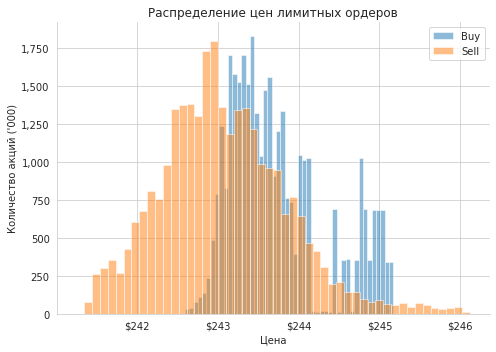

In [65]:
fig, ax = plt.subplots(figsize=(7, 5))
hist_kws = {'linewidth': 1, 'alpha': .5}
sns.distplot(buy[buy.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price,
            ax=ax, label='Buy', kde=False, hist_kws=hist_kws)
sns.distplot(sell[sell.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price,
            ax=ax, label='Sell', kde=False, hist_kws=hist_kws)

ax.legend(fontsize=10)
ax.set_title('Распределение цен лимитных ордеров')
ax.set_yticklabels([f'{int(y/1000):,}' for y in ax.get_yticks().tolist()])
ax.set_xticklabels([f'${int(x):,}' for x in ax.get_xticks().tolist()])
ax.set_xlabel('Цена')
ax.set_ylabel('Количество акций (\'000)')
sns.despine()
fig.tight_layout();

### Глубина ордерной книги

In [10]:
utc_offset = timedelta(hours=4)
depth = 100

In [ ]:
buy_per_min = (buy
              .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
              .shares
              .sum()
              .apply(np.log)
              .to_frame('shares')
              .reset_index('price')
              .between_time(market_open, market_close)
              .groupby(level='timestamp', as_index=False, group_keys=False)
              .apply(lambda x: x.nlargest(columns='price', n=depth))
              .reset_index())
buy_per_min.timestamp = buy_per_min.timestamp.add(utc_offset).astype(int)


In [ ]:
sell_per_min = (sell
                .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
                .shares
                .sum()
                .apply(np.log)
                .to_frame('shares')
                .reset_index('price')
                .between_time(market_open, market_close)
                .groupby(level='timestamp', as_index=False, group_keys=False)
                .apply(lambda x: x.nsmallest(columns='price', n=depth))
                .reset_index())

sell_per_min.timestamp = sell_per_min.timestamp.add(utc_offset).astype(int)
sell_per_min.info()

In [ ]:
with pd.HDFStore(order_book_store) as store:
    trades = store[f'{stock}/trades']
trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0].beetween_time[market_open, market_close]

trades_per_min = (trades
                 .resample('Min')
                 .agg({'price': 'mean', 'shares': 'sum'}))
trades_per_min.index = trades_per_min.index.to_series().add(utc_offset).astype(int)
trades_per_min.info()

График отбражает лимитные ордера и цены в течение одного торгового дня: темная кривая отображает соверщенных сделок в течение рыночных часов, тогда как красные точки отбражают поминутные лимитные ордера на продажу, а синие - на покупку 

In [ ]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(14, 6))

buy_per_min.plot.scatter(x='timestamp',
                         y='price', 
                         c='shares', 
                         ax=ax, 
                         colormap='Blues', 
                         colorbar=False, 
                         alpha=.25)

sell_per_min.plot.scatter(x='timestamp',
                          y='price', 
                          c='shares', 
                          ax=ax, 
                          colormap='Reds', 
                          colorbar=False, 
                          alpha=.25)

title = f'AAPL | {date} | Buy & Sell Limit Order Book | Depth = {depth}'
trades_per_min.price.plot(figsize=(14, 8), 
                          c='k', 
                          ax=ax, 
                          lw=2, 
                          title=title)

xticks = [datetime.fromtimestamp(ts / 1e9).strftime('%H:%M') for ts in ax.get_xticks()]
ax.set_xticklabels(xticks)

ax.set_xlabel('')
ax.set_ylabel('Price', fontsize=12)

red_patch = mpatches.Patch(color='red', label='Sell')
blue_patch = mpatches.Patch(color='royalblue', label='Buy')

plt.legend(handles=[red_patch, blue_patch])
sns.despine()
fig.tight_layout()